### 1. Clean raw answers

In [1]:
# List of CSV files representing different tasks
csv_files = [
    './direction_results.csv', 
    './length_results.csv', 
    './position_common_scale_results.csv', 
    './position_non_aligned_scale_results.csv',
    './angle_results.csv',
    './area_results.csv',
    './volume_results.csv',
    './curvature_results.csv',
    './shading_results.csv'
]

In [2]:
import pandas as pd
import numpy as np
import os
import re
from PIL import Image, ImageOps
import matplotlib.pyplot as plt

# Dictionary to store summary statistics for each task
summary_stats_by_task = {}

def clean_raw_answers(file_path):
    """
    Clean raw answers from CSV file, focusing only on extracting digits.
    
    Parameters:
    file_path (str): Path to the CSV file
    
    Returns:
    pandas.DataFrame: DataFrame with raw and cleaned answers
    """
    # Read the CSV file
    df = pd.read_csv(file_path)
    
    def extract_digits(x):
        if pd.isna(x):
            return np.nan
            
        # Convert to string
        x = str(x)
        
        # Remove newline characters and whitespace
        x = x.strip().replace('\n', '')
        
        # If string starts with "user", extract the last number
        if x.startswith('user'):
            numbers = re.findall(r'\d+\.?\d*', x)
            return float(numbers[-1]) if numbers else np.nan
            
        # Extract first number found
        numbers = re.findall(r'\d+\.?\d*', x)
        return float(numbers[0]) if numbers else np.nan
    
    # Create new column with cleaned values
    df['parsed_answers'] = df['raw_answers'].apply(extract_digits)

    # Print the row count before dropping NaN values
    print(f"Row count before dropping NaN for {len(df)}")
    
    # Drop rows with NaN in 'parsed_answers'
    df = df.dropna(subset=['parsed_answers'])

    # Format cleaned values as strings with one decimal point
    df['parsed_answers'] = df['parsed_answers'].apply(lambda x: '{:.1f}'.format(x) if not pd.isna(x) else x)

    return df

# Dictionary to store cleaned DataFrames for each file
cleaned_dataframes = {}

for file_path in csv_files:
    try:
        # Clean the raw answers and store in the dictionary with filename as key
        cleaned_df = clean_raw_answers(file_path)
        filename = os.path.basename(file_path).replace("_results.csv", "")  # Remove '_results.csv' to get the task name
        cleaned_dataframes[filename] = cleaned_df  # Store the cleaned DataFrame with the filename as key
        
    except Exception as e:
        print(f"Error processing {file_path}: {e}")  # Handle any errors (optional: log or pass)

# Access each cleaned DataFrame by task name
df_direction = cleaned_dataframes.get('direction')
df_length = cleaned_dataframes.get('length')
df_position_common_scale = cleaned_dataframes.get('position_common_scale')
df_position_non_aligned_scale = cleaned_dataframes.get('position_non_aligned_scale')
df_angle = cleaned_dataframes.get('angle')
df_area = cleaned_dataframes.get('area')
df_volume = cleaned_dataframes.get('volume')
df_curvature = cleaned_dataframes.get('curvature')
df_shading = cleaned_dataframes.get('shading')

Row count before dropping NaN for 305
Row count before dropping NaN for 305
Row count before dropping NaN for 305
Row count before dropping NaN for 305
Row count before dropping NaN for 305
Row count before dropping NaN for 305
Row count before dropping NaN for 305
Row count before dropping NaN for 305
Row count before dropping NaN for 305


### 2. Check dataframe if parsed answers match with raw answers

In [3]:
# Set display options to show all rows and all columns
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)  # Set to None to display full cell content

print("Direction dataframe after na value", len(df_direction))

df_direction.head()


Direction dataframe after na value 300


,model_name,run,image_path,ground_truth,raw_answers,forced_repetitions,time_ms,parsed_answers
0,gpt4o,run_0,EXP1-Results/direction/direction_image_1.png,104.0,135,0.0,6023.793697,135.0
1,gpt4o,run_0,EXP1-Results/direction/direction_image_2.png,212.0,45,0.0,5766.133070,45.0
2,gpt4o,run_0,EXP1-Results/direction/direction_image_3.png,215.0,50,0.0,5953.326941,50.0
3,gpt4o,run_0,EXP1-Results/direction/direction_image_4.png,68.0,35,0.0,6007.609367,35.0
4,gpt4o,run_0,EXP1-Results/direction/direction_image_5.png,70.0,40,0.0,6732.647181,40.0


### 3. Validate_parsed_answers = raw_answers

In [4]:
def validate_parsed_answers(df):
    """
    Validate the parsed_answers column by re-applying the extraction logic
    and comparing with parsed_answers.
    
    Parameters:
    df (pandas.DataFrame): DataFrame with raw_answers and parsed_answers
    
    Returns:
    pandas.DataFrame: DataFrame with validation results
    """
    
    def expected_parsed_answer(raw):
        if pd.isna(raw):
            return np.nan
            
        raw = str(raw).strip().replace('\n', '')
        
        # If string starts with "user", extract the last number
        if raw.startswith('user'):
            numbers = re.findall(r'\d+\.?\d*', raw)
            return float(numbers[-1]) if numbers else np.nan
        
        # Extract first number found
        numbers = re.findall(r'\d+\.?\d*', raw)
        return float(numbers[0]) if numbers else np.nan

    # Apply the validation logic to create an expected column
    df['expected_parsed'] = df['raw_answers'].apply(expected_parsed_answer)
    
    # Compare parsed_answers with expected_parsed
    df['is_correct'] = df['parsed_answers'].astype(float) == df['expected_parsed']
    
    # Filter mismatches for easy review
    mismatches = df[df['is_correct'] == False]
    
    # Display mismatches for manual review
    if not mismatches.empty:
        print("Mismatches found:")
        print(mismatches[['raw_answers', 'parsed_answers', 'expected_parsed']])
    else:
        print("All parsed answers match the expected values.")
        
    return mismatches

# Example usage on a DataFrame, e.g., df_direction
mismatches = validate_parsed_answers(df_direction)


All parsed answers match the expected values.


### 4. Display all 9 images tasks

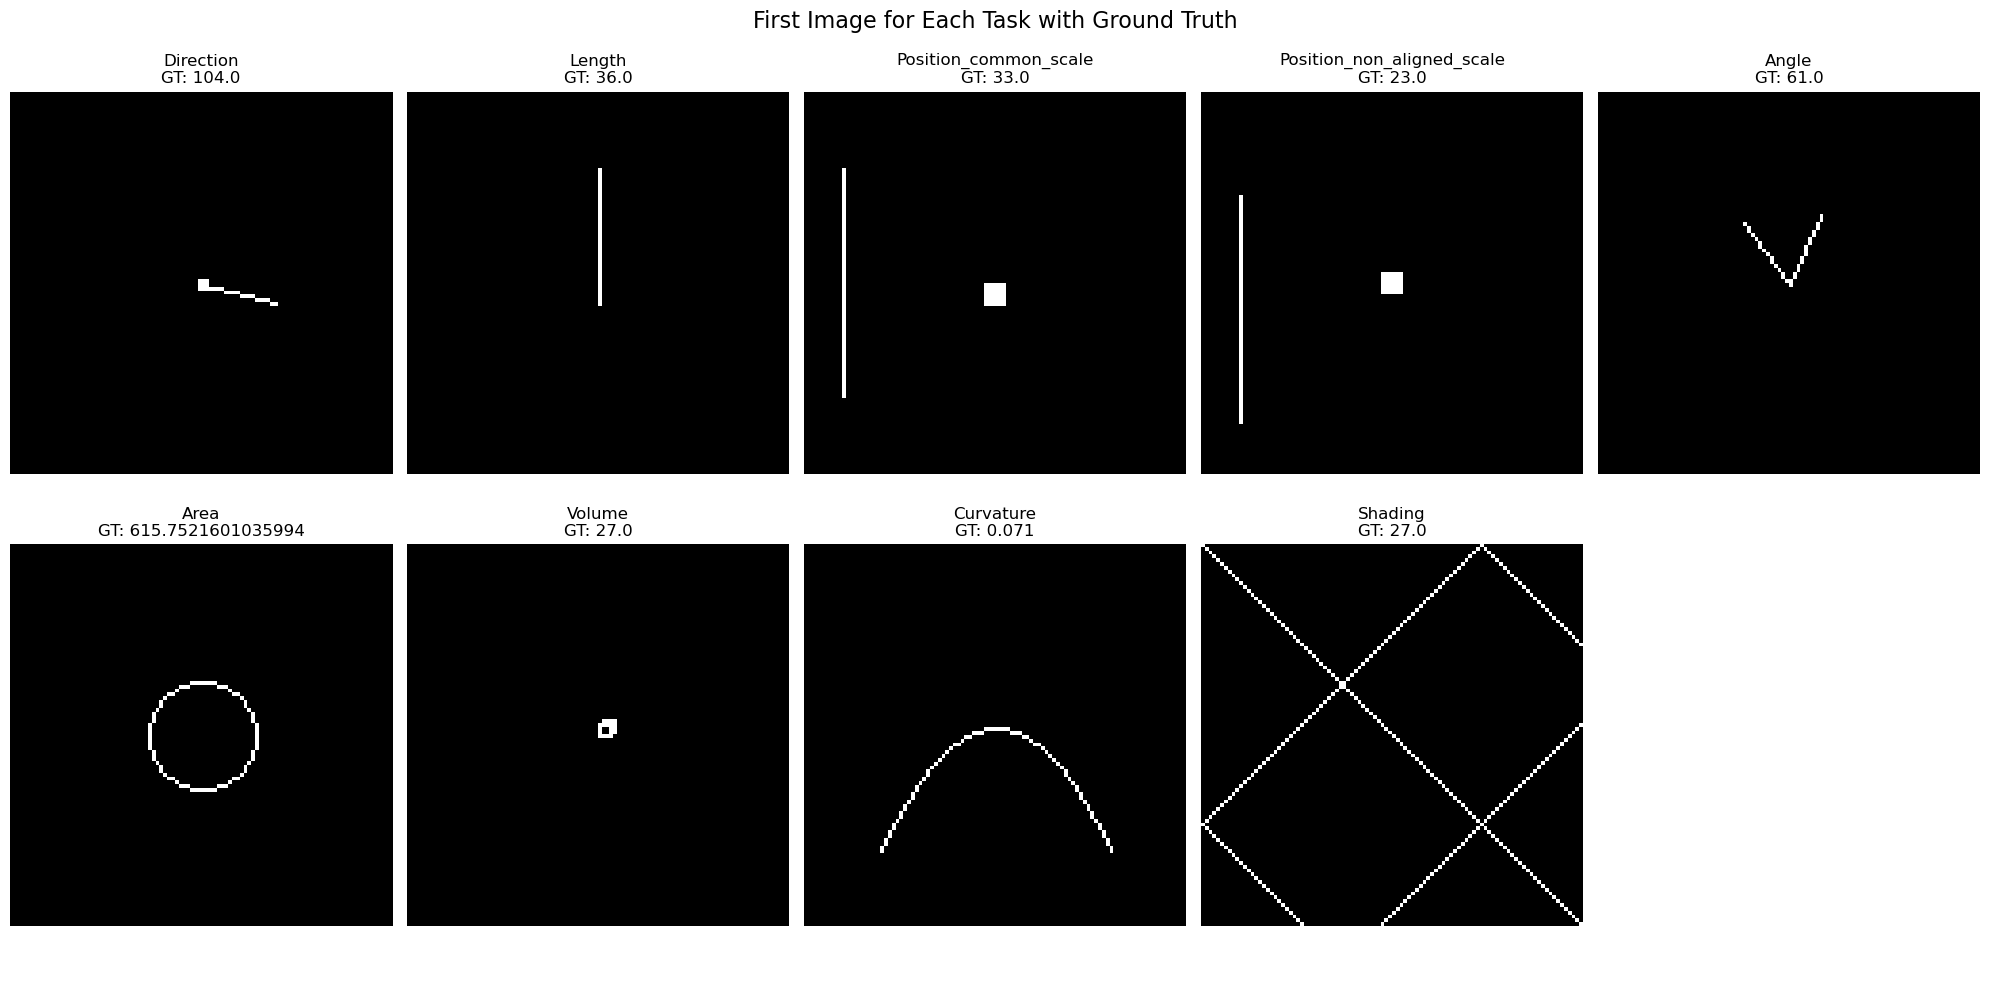

In [5]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

# Define the base folder where images are located
base_folder = "." 

# List of CSV files to read
csv_files = [
    './direction_results.csv', 
    './length_results.csv', 
    './position_common_scale_results.csv', 
    './position_non_aligned_scale_results.csv',
    './angle_results.csv',
    './area_results.csv',
    './volume_results.csv',
    './curvature_results.csv',
    './shading_results.csv'
]

# Number of columns for the plot
num_cols = 5
num_rows = 2

# Create a figure with subplots for displaying images in 2 rows
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 10))
fig.suptitle("First Image for Each Task with Ground Truth", fontsize=16)

# Flatten axes for easy iteration if there are multiple rows
axes = axes.flatten()

# Loop through each CSV file and display the first image for each task
for idx, csv_file in enumerate(csv_files):
    # Check if there is an available axis for this image
    if idx >= num_rows * num_cols:
        break
    
    # Read the CSV file
    if not os.path.exists(csv_file):
        print(f"CSV file not found: {csv_file}")
        continue

    results_df = pd.read_csv(csv_file)

    # Extract the task name from the CSV filename (e.g., 'angle' from 'angle_results.csv')
    task = os.path.basename(csv_file).replace('_results.csv', '')

    # Get the first row to display the first image for this task
    first_row = results_df.iloc[0]
    
    # Extract the filename only from the image path
    image_filename = os.path.basename(first_row["image_path"])  # e.g., 'angle_image_6.png'
    
    # Construct the path with base_folder and the filename
    image_path = os.path.join(base_folder, task, image_filename)  # e.g., './angle/angle_image_6.png'
    ground_truth = first_row["ground_truth"]

    # Display the image in the subplot
    if os.path.exists(image_path):
        img = Image.open(image_path)
        axes[idx].imshow(img, cmap="gray")
        axes[idx].set_title(f"{task.capitalize()}\nGT: {ground_truth}")
    else:
        print(f"Image not found: {image_path}")
        axes[idx].set_title(f"{task.capitalize()}\nImage not found")
    
    axes[idx].axis("off")

# Hide any remaining empty subplots
for j in range(idx + 1, num_rows * num_cols):
    axes[j].axis("off")

plt.tight_layout()
plt.show()


### 5. Caculate all metrics

In [7]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error
import bootstrapped.bootstrap as bs
import bootstrapped.stats_functions as bs_stats


# Dictionary to store metrics for each dataset
metrics_summary = {}

dataframes = {
    'df_direction': df_direction,
    'df_length': df_length,
    'df_position_common_scale': df_position_common_scale,
    'df_position_non_aligned_scale': df_position_non_aligned_scale,
    'df_angle': df_angle,
    'df_area': df_area,
    'df_volume': df_volume,
    'df_curvature': df_curvature,
    'df_shading': df_shading
}

# Loop through each dataset
for df_name, df in dataframes.items():
    # Dictionary to store metrics for each model within the current DataFrame
    model_metrics = {}
    
    # Group by `model_name` and calculate metrics for each model within the dataset
    for model_name, data in df.groupby('model_name'):
        # Ensure `ground_truth` and `parsed_answers` columns are numeric, converting non-numeric values to NaN
        data['ground_truth'] = pd.to_numeric(data['ground_truth'], errors='coerce')
        data['parsed_answers'] = pd.to_numeric(data['parsed_answers'], errors='coerce')
        
        # Drop rows where either `ground_truth` or `parsed_answers` is NaN after conversion
        data = data.dropna(subset=['ground_truth', 'parsed_answers'])
        
        # Calculate Mean and Standard Deviation of `parsed_answers`
        mean_parsed_answers = data['parsed_answers'].mean()
        std_parsed_answers = data['parsed_answers'].std()
        
        # Calculate Mean Squared Error (MSE)
        data['mse'] = (data['ground_truth'] - data['parsed_answers']) ** 2
        avg_mse = data['mse'].mean()
        
        # Calculate Mean Log Absolute Error (MLAE)
        data['mlae'] = data.apply(
            lambda row: np.log2(mean_absolute_error([row['ground_truth']], [row['parsed_answers']]) + 0.125),
            axis=1
        )
        
        # Calculate average MLAE and standard deviation of MLAE
        avg_mlae = data['mlae'].mean()
        std_mlae = data['mlae'].std()
        
        # Bootstrap confidence interval for MLAE
        mlae_values = data['mlae'].dropna().values  # Drop NaN values, if any
        bootstrap_result = bs.bootstrap(np.array(mlae_values), stat_func=bs_stats.std)
        confidence_value = 1.96 * bootstrap_result.value  # 95% confidence interval margin for std (using 1.96 Z-score)

        # Store metrics in the model_metrics dictionary
        model_metrics[model_name] = {
            'Dataset': df_name,
            'Model': model_name,
            #'Mean Parsed Answers': round(mean_parsed_answers, 2),
            #'Std Parsed Answers': round(std_parsed_answers, 2),
            #'Average MSE': round(avg_mse, 2),
            'Average MLAE': round(avg_mlae, 2),
            'Std MLAE': round(std_mlae, 2),
            'Confidence Interval (95%)': round(confidence_value, 2)
        }
    
    # Store model metrics for the current dataset
    metrics_summary[df_name] = model_metrics

# Convert the nested metrics_summary dictionary to a DataFrame for easy viewing
metrics_table = pd.DataFrame([
    metrics for dataset_metrics in metrics_summary.values() for metrics in dataset_metrics.values()
])

# Display the resulting table
metrics_table


,Dataset,Model,Average MLAE,Std MLAE,Confidence Interval (95%)
0,df_direction,CustomLLaMA,2.02,1.18,2.30
1,df_direction,Gemini1_5Flash,6.15,1.33,2.58
2,df_direction,GeminiProVision,6.46,1.45,2.81
3,df_direction,LLaMA,6.10,1.41,2.75
4,df_direction,gpt4o,5.99,1.70,3.31
5,df_length,CustomLLaMA,-0.14,1.83,3.56
6,df_length,Gemini1_5Flash,4.62,1.31,2.55
7,df_length,GeminiProVision,5.61,0.59,1.15
8,df_length,LLaMA,4.55,1.92,3.72
9,df_length,gpt4o,2.74,1.97,3.83


### 6. Plot MLAE for all models


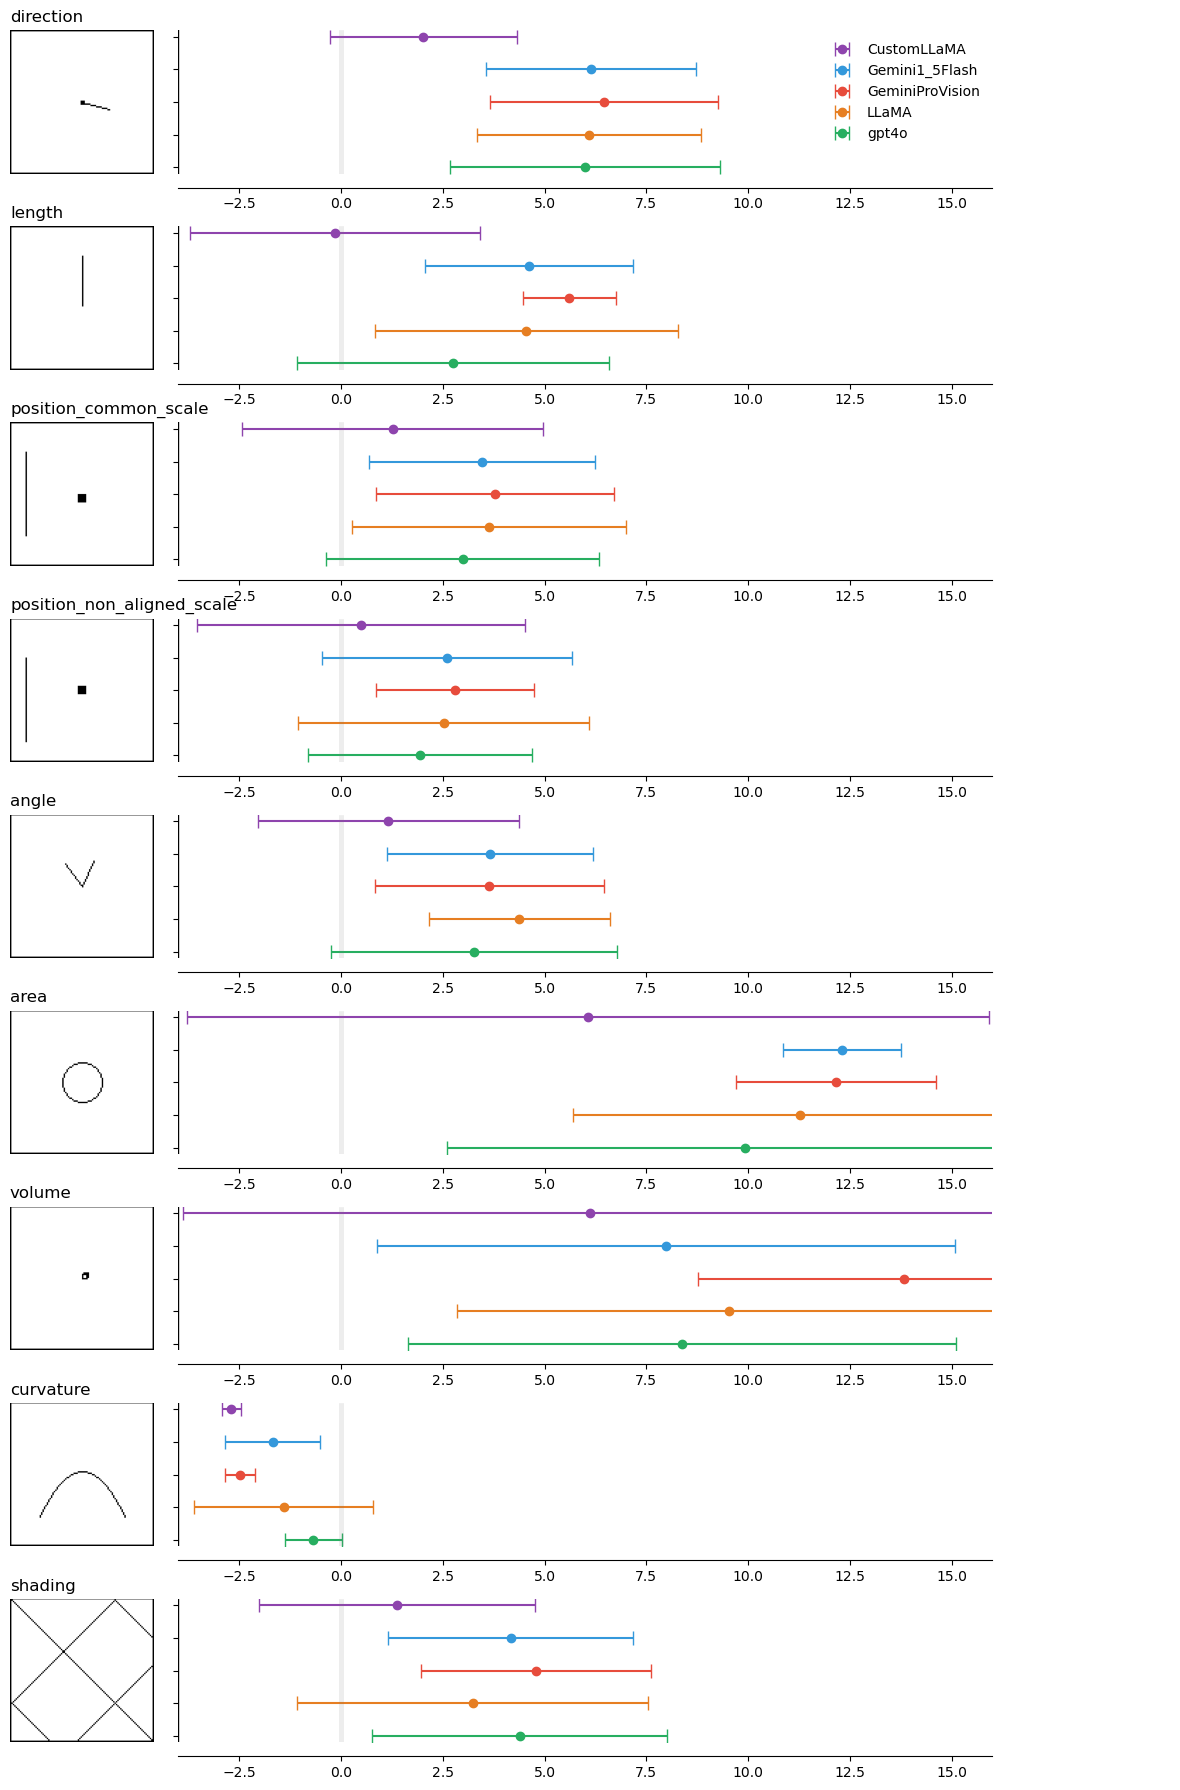

In [9]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import os

import os

# Group data by dataset for easier access
summary_stats_by_task = {df_name: metrics_table[metrics_table['Dataset'] == df_name] for df_name in metrics_table['Dataset'].unique()}

# Set the base directory
base_dir = '/home/huuthanhvy.nguyen001/tmp/LLMP/EXP/EXP1-Results-5000'

# Define task images relative to the base directory
task_images = {
    'direction': os.path.join(base_dir, 'direction', 'direction_image_1.png'),
    'length': os.path.join(base_dir, 'length', 'length_image_1.png'),
    'position_common_scale': os.path.join(base_dir, 'position_common_scale', 'position_common_scale_image_1.png'),
    'position_non_aligned_scale': os.path.join(base_dir, 'position_non_aligned_scale', 'position_non_aligned_scale_image_1.png'),
    'angle': os.path.join(base_dir, 'angle', 'angle_image_1.png'),
    'area': os.path.join(base_dir, 'area', 'area_image_1.png'),
    'volume': os.path.join(base_dir, 'volume', 'volume_image_1.png'),
    'curvature': os.path.join(base_dir, 'curvature', 'curvature_image_1.png'),
    'shading': os.path.join(base_dir, 'shading', 'shading_image_1.png')
}

# Check if each path exists and print
#for task, img_path in task_images.items():
    #print(f"Path for {task}: {img_path} - Exists: {os.path.isfile(img_path)}")


# Define colors for each model
model_colors = {
    'CustomLLaMA': '#8E44AD',       # Purple
    'Gemini1_5Flash': '#3498DB',    # Blue
    'GeminiProVision': '#E74C3C',   # Red
    'LLaMA': '#E67E22',             # Orange
    'gpt4o': '#27AE60'              # Green
}

# Plot configuration
num_tasks = len(summary_stats_by_task)
fig, axes = plt.subplots(num_tasks, 3, figsize=(12, 2 * num_tasks), 
                         gridspec_kw={'width_ratios': [1, 5, 1]}, sharex=False)
fig.subplots_adjust(hspace=0.5, wspace=0.3, left=0.05, right=0.95, top=0.95, bottom=0.05)
fig.patch.set_facecolor('white')

# Convert `axes` to 2D array if only one row of subplots
if num_tasks == 1:
    axes = axes.reshape(1, -1)

# Loop through each task (dataset) and its summary stats
for i, (task_name, task_data) in enumerate(summary_stats_by_task.items()):
    ax_img, ax_plot, ax_label = axes[i]

    # Clean task name to match keys in `task_images`
    cleaned_task_name = task_name.replace("df_", "")
    
    # Use the cleaned name to access the correct image path
    img_path = task_images.get(cleaned_task_name)
    
    # Display task image if available
    if os.path.exists(img_path):
        try:
            img = Image.open(img_path).convert("L")
            img_inverted = ImageOps.invert(img)
            img_with_border = ImageOps.expand(img_inverted.convert("RGB"), border=1, fill="black")
            ax_img.imshow(img_with_border)
            ax_img.axis('off')  # Hide axes for the image plot

        except Exception as e:
            #print(f"Error displaying image for {task_name}: {e}")
            ax_img.text(0.5, 0.5, "Error displaying image", ha="center", va="center", fontsize=10, color="black")
            ax_img.set_facecolor("white")
    else:
        #print(f"Image not found: {img_path}")
        ax_img.text(0.5, 0.5, "Image not found", ha="center", va="center", fontsize=10, color="black")
        ax_img.set_facecolor("white")

    # Sort model names alphabetically and get y positions
    sorted_model_names = sorted(task_data['Model'].unique())
    y_positions = np.arange(len(sorted_model_names))

    # Plot MLAE and error bars in the middle
    for j, model_name in enumerate(sorted_model_names):
        model_data = task_data[task_data['Model'] == model_name]
        mlae_value = model_data['Average MLAE'].values[0]
        confidence_interval = model_data['Confidence Interval (95%)'].values[0]

        ax_plot.errorbar(mlae_value, j, xerr=confidence_interval, fmt='o', 
                         color=model_colors.get(model_name, 'gray'), capsize=5, 
                         label=f"{model_name}" if i == 0 else None)

    # Add reference lines
    ax_plot.axvline(-4, color="black", linewidth=1)
    ax_plot.axvline(-14, color="black", linewidth=1)
    
    # Add blurred line at 0
    for offset in np.linspace(-0.05, 0.05, 10):
        ax_plot.axvline(0 + offset, color="gray", alpha=0.1, linewidth=0.5)

    # Customize plot appearance
    ax_plot.grid(False)
    ax_plot.spines['top'].set_visible(False)
    ax_plot.spines['right'].set_visible(False)
    ax_plot.spines['left'].set_visible(False)
    ax_plot.spines['bottom'].set_position(('outward', 10))

    # Set axis properties
    ax_plot.set_yticks(y_positions)
    ax_plot.set_yticklabels([])
    ax_plot.set_xlim(-4, 16)
    ax_plot.invert_yaxis()

    # Clean task name and set title
    cleaned_task_name = task_name.replace("df_", "")
    ax_img.set_title(cleaned_task_name, loc="left", fontsize=12, color="black")

    # Configure right labels
    ax_label.set_yticks(y_positions)
    ax_label.set_yticklabels(sorted_model_names, fontsize=10)
    ax_label.tick_params(left=False, right=False, labelleft=False, labelright=True)
    ax_label.set_ylim(ax_plot.get_ylim())
    ax_label.axis("off")

# Add legend to the first row
axes[0, 1].legend(loc="best", frameon=False)

# Ensure tight layout
plt.tight_layout()
plt.show()


### 7. Filter and sort model data and caculate for each model

In [8]:
def filter_and_sort_df(df, model_name="all"):
    """
    Filter and sort the df DataFrame by model name, removing '.0' for integer values.
    
    Parameters:
    - df: pandas.DataFrame, the DataFrame to filter and sort
    - model_name: str, specific model name to filter or "all" for all models
    
    Returns:
    - pandas.DataFrame: The filtered and sorted DataFrame without styling
    """
    # Filter by model name or select all
    if model_name != "all":
        filtered_df = df[df['model_name'] == model_name]
    else:
        filtered_df = df

    # Sort by 'ground_truth' and 'parsed_answers'
    filtered_sorted_df = filtered_df.sort_values(by=['ground_truth', 'parsed_answers'])
    
    # Convert 'ground_truth' and 'parsed_answers' to integer if they are whole numbers
    filtered_sorted_df['ground_truth'] = filtered_sorted_df['ground_truth'].apply(
        lambda x: int(float(x)) if float(x).is_integer() else float(x)
    )
    filtered_sorted_df['parsed_answers'] = filtered_sorted_df['parsed_answers'].apply(
        lambda x: int(float(x)) if float(x).is_integer() else float(x)
    )

    return filtered_sorted_df[['ground_truth', 'parsed_answers', 'model_name']]



In [14]:
# Usage example
# Display the DataFrame for a specific model, e.g., "CustomLLaMA"
data = filter_and_sort_df(df_area, model_name="all")

data

,ground_truth,parsed_answers,model_name
251,78.539816,1178.1,Gemini1_5Flash
290,78.539816,1570.8,Gemini1_5Flash
284,78.539816,2463.0,Gemini1_5Flash
261,78.539816,2500.0,Gemini1_5Flash
61,78.539816,28.3,CustomLLaMA
67,78.539816,28.3,CustomLLaMA
68,78.539816,28.3,CustomLLaMA
78,78.539816,28.3,CustomLLaMA
81,78.539816,28.3,CustomLLaMA
87,78.539816,28.3,CustomLLaMA


### 8. Display 20 images for each task

In [138]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

# Define the base folder where images are located
base_folder = "." 

# Dictionary of CSV files for each task
csv_files = {
    'direction': './direction_results.csv', 
    'length': './length_results.csv', 
    'position_common_scale': './position_common_scale_results.csv', 
    'position_non_aligned_scale': './position_non_aligned_scale_results.csv',
    'angle': './angle_results.csv',
    'area': './area_results.csv',
    'volume': './volume_results.csv',
    'curvature': './curvature_results.csv',
    'shading': './shading_results.csv'
}

def display_images(num_images, tasks="all"):
    # Use all tasks if 'tasks' parameter is "all"
    selected_tasks = list(csv_files.keys()) if tasks == "all" else tasks

    # Calculate total number of subplots needed
    total_images = len(selected_tasks) * num_images
    num_cols = 5
    num_rows = (total_images + num_cols - 1) // num_cols  # Automatically adjust rows

    # Create figure with subplots
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 3))
    fig.suptitle(f"Displaying {num_images} Images per Task with Ground Truth", fontsize=16)
    
    # Flatten axes for easy iteration
    axes = axes.flatten()

    plot_idx = 0  # To keep track of the current subplot index
    for task in selected_tasks:
        # Check if the CSV file exists for the task
        csv_file = csv_files.get(task)
        if not os.path.exists(csv_file):
            print(f"CSV file not found: {csv_file}")
            continue

        # Load CSV data
        results_df = pd.read_csv(csv_file)

        # Limit to num_images or the number of rows in the CSV, whichever is smaller
        num_to_display = min(num_images, len(results_df))

        # Loop to display each image for the task
        for i in range(num_to_display):
            if plot_idx >= num_rows * num_cols:
                break
            
            # Get the row data and image path
            row = results_df.iloc[i]
            image_filename = os.path.basename(row["image_path"])
            image_path = os.path.join(base_folder, task, image_filename)
            ground_truth = row["ground_truth"]

            # Display image if exists, else show 'Image not found'
            if os.path.exists(image_path):
                img = Image.open(image_path)
                axes[plot_idx].imshow(img, cmap="gray")
                axes[plot_idx].set_title(f"{task.capitalize()}\nGT: {ground_truth}")
            else:
                print(f"Image not found: {image_path}")
                axes[plot_idx].set_title(f"{task.capitalize()}\nImage not found")

            axes[plot_idx].axis("off")
            plot_idx += 1

    # Hide any remaining empty subplots
    for j in range(plot_idx, num_rows * num_cols):
        axes[j].axis("off")

    plt.tight_layout()
    plt.show()


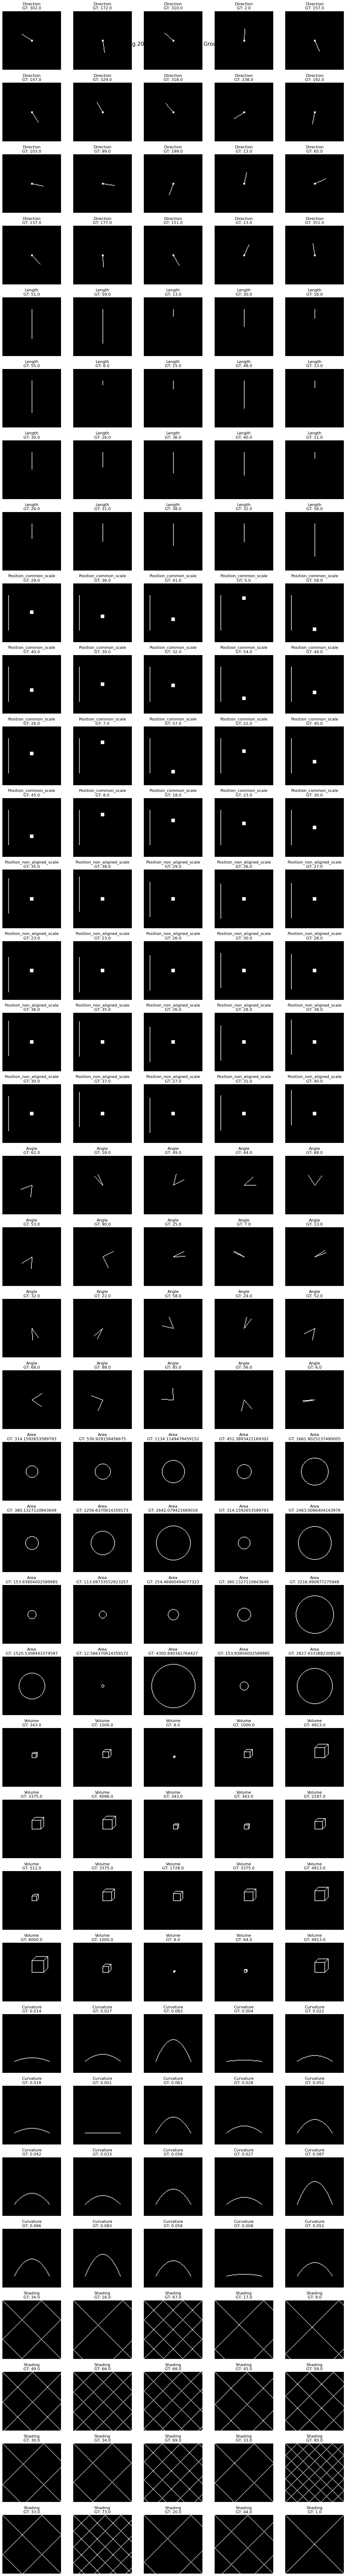

In [4]:
# Call the function with specific number of images and tasks
display_images(num_images=20, tasks="all")